<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance d'Activité Humaine](https://github.com/wikistat/Ateliers-Big-Data/5-HumanActivityRecognition) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-Learn"/></a>
##  Traitements élémentaires des variables "métier"
### Résumé
Ce cas d'usage de reconnaissance d'activités humaines à partir des enregistrements d'un smartphone (gyroscope, accéléromètre) est traité pour illustrer les principales étapes d'exploration et apprentissae communes en *science des données*. Exploration multidimensionnelle par méthode factorielle, classification non supervisée, avant d'aborder le problème de classification non supervisée pour prévoir l'activité. Plusieurs méthodes, sont apprises sur l'échantillon d'apprentissage, certaines, optimisées par validation croisée, puis leurs performances comparées sur la qualité de prévision de l'échantillon test.


**Sommaire**

     3. Exploration
     4. Apprentissage et prévision avec des methodes "classiques" optimisées d'apprentissage machine
     5. Combinaisons de méthodes
     6. Annexe: Outil d'aide à l'optimisation

## 1 Introduction
### 1.1 Contexte
Les données sont issues de la communauté qui vise la reconnaissance d'activités humaines (*Human activity recognition, HAR*) à partir d’enregistrements, par exemple du gyroscope et de l'accéléromètre d'un smartphone. Voir à ce propos l'[article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) relatant un colloque de 2013.  

Les données publiques disponibles et largement étudiées ont été acquises, décrites et analysées par [Anguita et al. (2013)](). Elles sont accessibles sur le [dépôt](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) de l'University California Irvine (UCI) consacré à l'apprentissage machine ainsi que sur le site *Kaggle*.

L'archive contient les données brutes: accélérations en x, y, et z, chacun de 128 colonnes. D'autres fichiers en y soustrayant la gravité naturelle ainsi que les accélérations angulaires en x, y, et z soit en tout 9 fichiers. Mais 6 utiles avec 6*128=768 mesures.

Elle contient également deux fichiers "train" et "test" de *features* ou variables métier calculées dans les domaines temporels et fréquentiels: 561 variables.

Les données sont labellisées avec 6 activités: debout, assis, couché, marche, monter ou descendre un escalier. Il s'agit donc d'un problème de classification supervisée (6 classes) avec 10299 observations pour l'apprentissage, 2947 pour le test, décrites par 561 variables.

Voici une liste indicative des variables calculées sur chacune des variables initiales et couples de variables:

Name|Signification
-|-
mean | Mean value
std | Standard deviation
mad | Median absolute value
max | Largest values in array
min | Smallest value in array
sma | Signal magnitude area
energy | Average sum of the squares
iqr | Interquartile range
entropy | Signal Entropy
arCoeff | Autorregresion coefficients
correlation | Correlation coefficient
maxFreqInd | Largest frequency component
meanFreq | Frequency signal weighted average
skewness | Frequency signal Skewness
kurtosis | Frequency signal Kurtosis
energyBand | Energy of a frequency interval
angle | Angle between two vectors

### 1.2 Objectifs
Cette *première étape* s'intéresse aux seules variables construites à partir des connaissances *a priori* du comportement des capteurs en fonction des types d'activité humaine. Ce premier calepin propose une exploration et une modélisation, des 561 variables métier. Il s'agit de répondre à la question: quel algorihtme d'apprentissage permet de déterminer au mieux l'activité humaine? 

Une *deuxième étape*  s'intéresse aux données brutes. Est-il possible d'économiser le travail préliminaire de définition des variables métier en utilisant, par exemple, des décompositions systématiques sur une base d'ondelettes ou mieux un algorihtme d'apprentissage profond sur les seules données brutes? L'enjeu est d'obtenir une discrimination sur les données brutes donc moins énergivores qu'un calcul préalable des caractéristiques métier.

In [1]:
# Importaiton des principals librairies et 
# Affichage des graphiques dans le notebook
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
## help --> http://xgboost.readthedocs.io/en/latest//python/python_api.html


## 2 Lecture des données

Les données peuvent être préalablement téléchargées ou directement lues. Ce sont celles originales du dépôt de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). 

In [2]:
# Lecture des données d'apprentissage
# Attention, il peut y avoir plusieurs espaces comme séparateur dans le fichier
Xtrain=pd.read_table("X_train.txt",sep='\s+',header=None)
Xtrain.head()

0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9      ...          551       552       553  \
0 -0.983185 -0.923527 -0.934724    ...    -0.074323 -0.298676 -0.710304   
1 -0.974914 -0.957686 -0.943068    ...     0.158075 -0.595051 -0.861499   
2 -0.963668 -0.977469 -0.938692    ...     0.414503 -0.390748 -0.760104   
3 -0.982750 -0.989302 -0.938692    ...     0.404573 -0.117290 -0.482845   
4 -0.979672 -0.990441 -0.942469    ...     0.087753 -0.351471 -0.699205   

        554       555       556       557       558       559       560  
0 -0.112754  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1  0.053477 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2 -0.118559  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3 -0.036788 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4  0.123320  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  

[5 rows x 561 columns]

In [3]:
# Variable cible
ytrain=pd.read_table("y_train.txt",sep='\s+',header=None,names=('y'))
# Le type dataFrame est inutile et même gênant pour les la suite
ytrain=ytrain["y"]

In [4]:
# Lecture des données de test
Xtest=pd.read_table("X_test.txt",sep='\s+',header=None)
Xtest.shape

(2947, 561)

In [5]:
ytest=pd.read_table("y_test.txt",sep='\s+',header=None,names=('y'))
ytest=ytest["y"]
# Significaiton des codes de y
label_dic = {1 : "Marcher",2 : "Monter escalier",3 : "Descendre escalier",
   4 : "Assis",5 : "Debout",6 : "Couche"}
labels = label_dic.values()

## 3 Exploration
### 3.1 [Analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf)
#### Principe
Il est important de se faire une idée précise de la structure des données.  Une analyse en composantes principales est adaptée à cet objectif. 

   - Elle recherche les axes de plus grande dispersion du nuages des individus dans $R^p$ avec $p=561$. Ces axes sont définis par les vecteurs propres de la matrice des covariances ou des corrélations si les variables sont réduites (divisées par l'écart-type).
   - Les représentations graphiques des individus sont obtenues par projection sur les sous-espaces engendrés par les premiers vecteurs propres. Elles préservent au mieux les distances entre ceux-ci.
   - Les coordonnées sont stockées dans la matrice des *composantes principales* qui sont aussi les combinaisons linéaires de plus grande variance des variables. Ce sont des variables décorrélées, orthogonales deux à deux.
   - Les representations graphiques des variables initiales conservent au mieux les angles entre les vecteurs variables dans l'espace $R^n$ de façon à interpréter leurs corrélations qui, géométriquement, sont les cosinus de ces angles. 

La fonction définie ci-après affiche un nuage de points dans un plan factoriel.

In [7]:
def plot_pca(X_R,fig,ax,nbc,nbc2):
    for i in range(6):
        xs = X_R[ytrain==i+1,nbc-1]
        ys = X_R[ytrain==i+1, nbc2-1]
        label = label_dic[i+1]
        color = cmaps(i)
        ax.scatter(xs, ys, color=color, alpha=.8, s=1, label=label)
        ax.set_xlabel("PC%d : %.2f %%" %(nbc,pca.explained_variance_ratio_[nbc-1]*100), fontsize=10)
        ax.set_ylabel("PC%d : %.2f %%" %(nbc2,pca.explained_variance_ratio_[nbc2-1]*100), fontsize=10)

Calcul de la matrice des composantes principales. C'est aussi un changement (transformation) de base; de la base canonique dans la base des vecteurs propres. 

In [8]:
pca = PCA()
X_r = pca.fit_transform(Xtrain)

#### Valeurs propres ou variances des composantes principales
Représentation de la décroissance des valeurs propres, les variances des variables ou composantes principales.

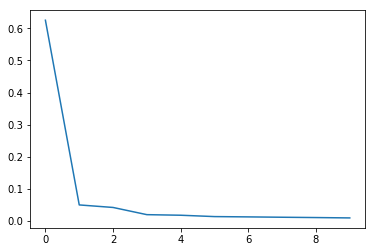

In [9]:
plt.plot(pca.explained_variance_ratio_[0:10])
plt.show()

Un graphique plus explicite décrit les distribution de ces composantes par des diagrames boîtes; seules les premières sont affichées. 

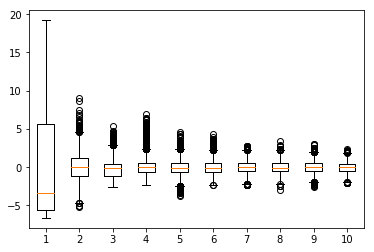

In [10]:
plt.boxplot(X_r[:,0:10])
plt.show()

Commenter la décroissance des variances, le choix éventuel d'une dimension ou nombre de composantes à retenir sur les 561.
#### Représentation des individus
Projection dans les principaux plans factoriels.

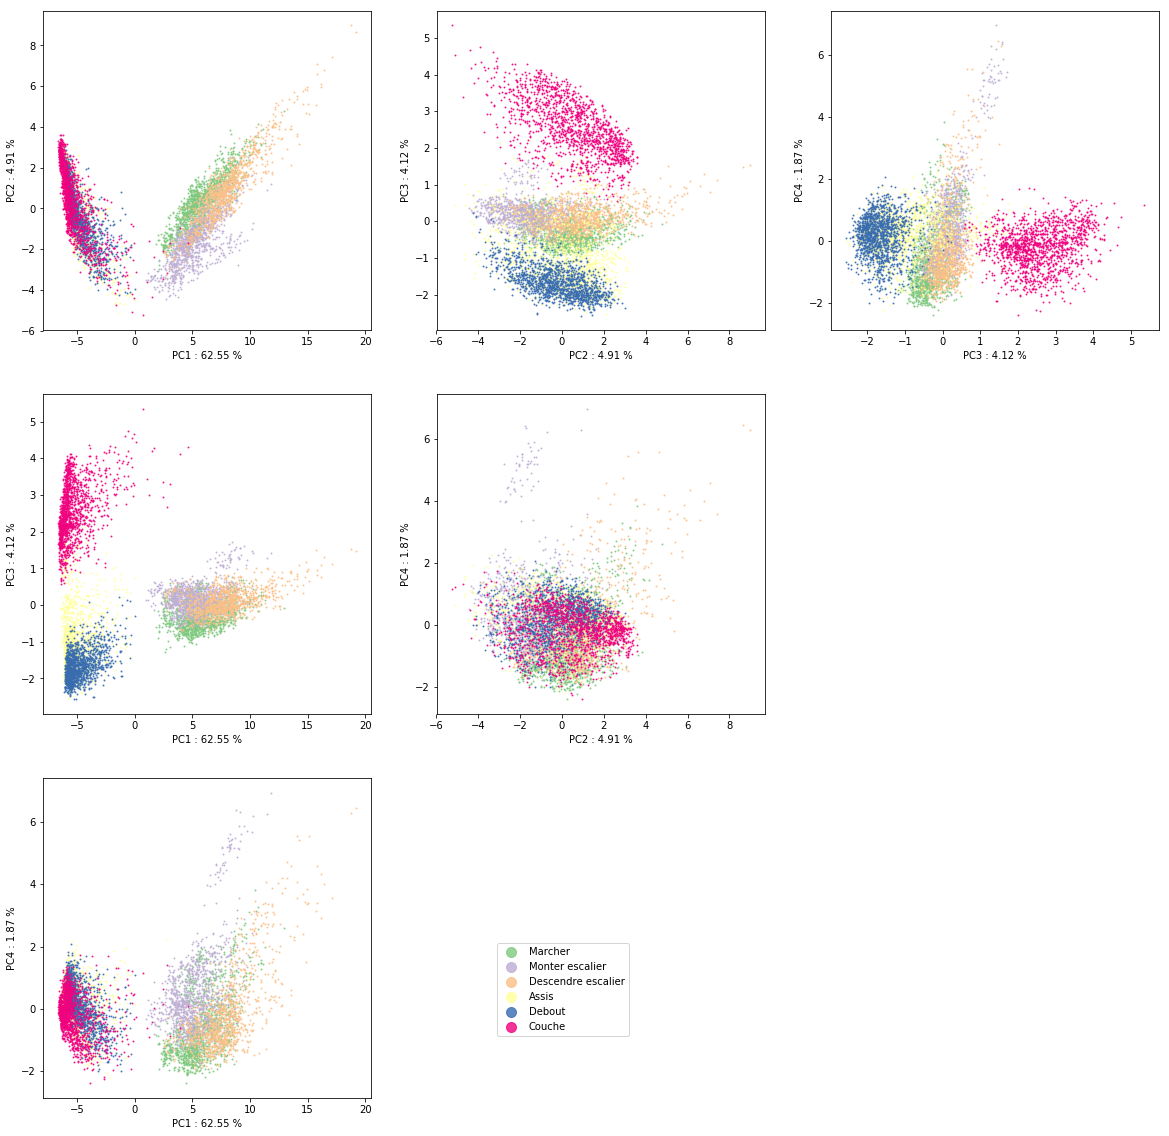

In [11]:
cmaps = plt.get_cmap("Accent")
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    plot_pca(X_r, fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.5), markerscale=10)
plt.show()

**Q** Commenter la séparation des deux types de situation par le premier axe.

**Q** Que dire sur la forme des nuages?

**Q** Que dire sur la plus ou moins bonne séparation des classes?


#### Représentation des variables
Lecture des libellés des variables et constitution d'une liste. Souci de la grande dimension (561), les représentations ne sont guère exploitables. 

In [12]:
with open('features.txt', 'r') as content_file:
    featuresNames = content_file.read()
columnsNames = list(map(lambda x : x.split(" ")[1],featuresNames.split("\n")[:-1]))

Graphe illisible en mettant les libellés en clair. Seule une * est représentée.

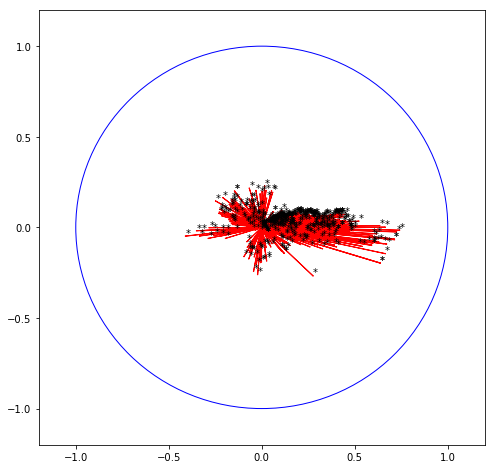

In [13]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j in zip(coord1,coord2, ):
    plt.text(i, j, "*")
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

Identificaiton des variables participant le plus au premier axe. Ce n'est pas plus clair! Seule la réprésentation des individus apporte finalement des éléments de compréhension.

In [14]:
np.array(columnsNames)[abs(coord1)>.6]

array(['tBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Y',
       'tBodyAccMag-entropy()', 'tGravityAccMag-entropy()',
       'tBodyAccJerkMag-entropy()', 'tBodyGyroJerkMag-entropy()',
       'fBodyAcc-entropy()-X', 'fBodyAcc-entropy()-Y',
       'fBodyAcc-entropy()-Z', 'fBodyAccJerk-entropy()-X',
       'fBodyAccJerk-entropy()-Y', 'fBodyAccJerk-entropy()-Z',
       'fBodyAccMag-entropy()', 'fBodyBodyAccJerkMag-entropy()',
       'fBodyBodyGyroJerkMag-entropy()'],
      dtype='<U36')

### 3.2 [Analyse Factorielle Discriminante (AFD)](http://wikistat.fr/pdf/st-m-explo-afd.pdf)
#### Principe
L'ACP ne prend pas en compte la présence de la variable qualitative à modéliser contrairement à l'analyse factorielle discriminante qui calcule l'ACP des barycentres des classes. De plus, l'espace des indivudus est muni d'une métrique spécifique: *Mahalanobis*. L'objectif est alors de visualiser les capacités des variables à discriminer les classes.

La librairie `scikit-learn` ne propose pas de fonction spécifique d'analyse factorielle discriminante mais les coordonnées des individus dans la base des vecteurs discriminants sont obtenues comme résultats de l'analyse discriminante linéaire décisionnnelle. Cette dernière sera utilisé avec une finalité prédictive dans un deuxième temps.

In [15]:
method = LinearDiscriminantAnalysis() 
lda=method.fit(Xtrain,ytrain)
X_r2=lda.transform(Xtrain)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [42]:
Xtest_afd=lda.transform(Xtest)

#### Représentation des individus

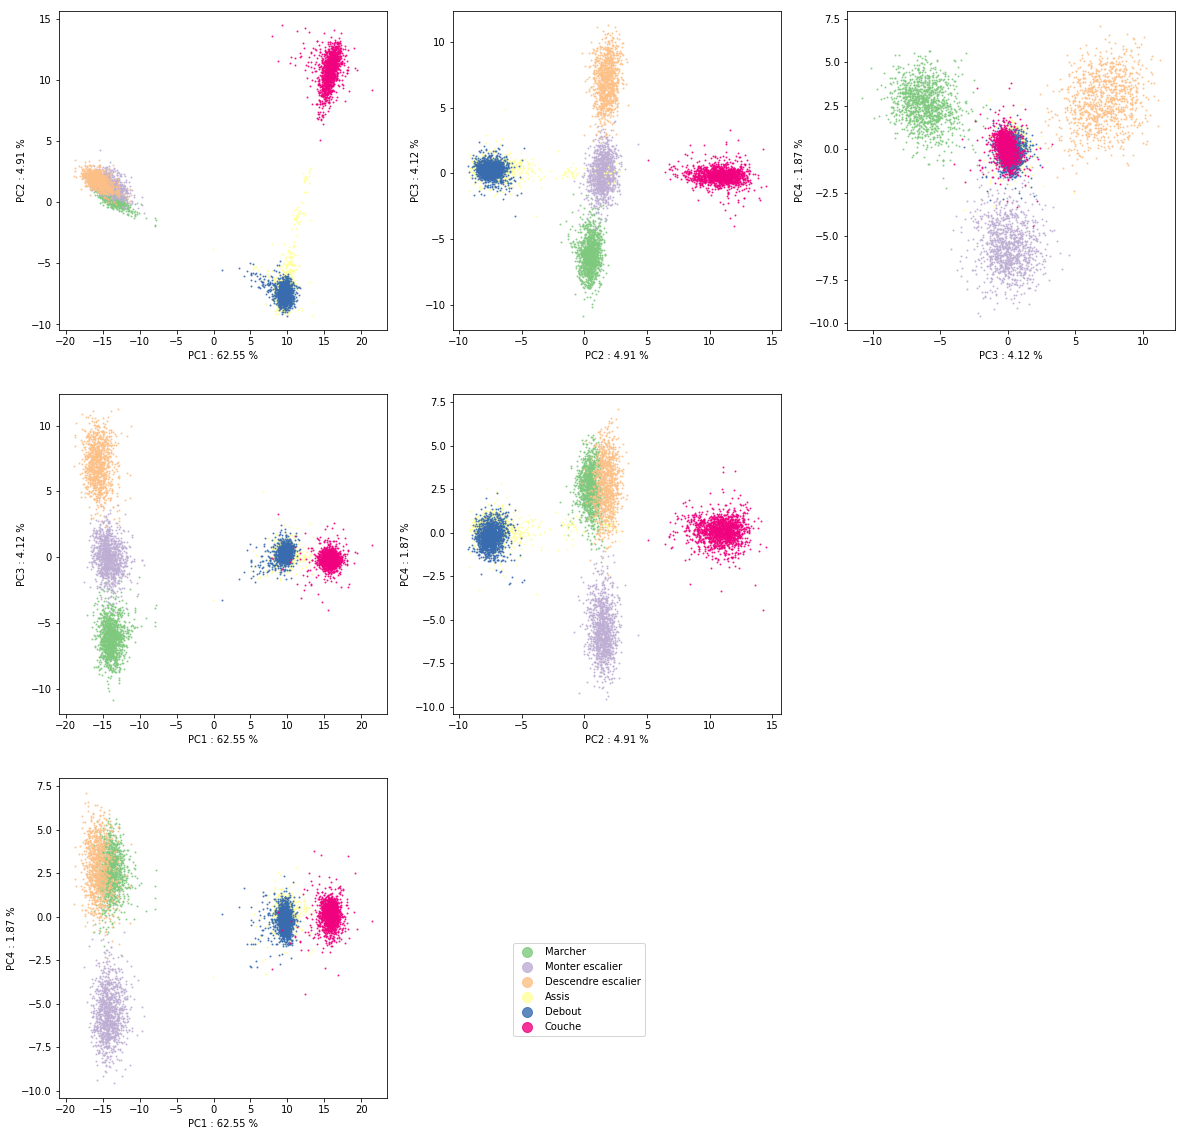

In [16]:
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    plot_pca(X_r2, fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.5), markerscale=10)
plt.show()

**Q** Que dire de la séparation des classes. Sont-elles toutes séparables deux à deux?

**Q** Que dire de la forme des nuages notamment dans le premier plan?

Comme pour l'ACP, la représentation des variables n'apporte rien.

### 3.3 Classification non supervisée avec $k$*-means*
Cette section n'est pas utile, puisque les classes sont connues, mais elle permet d'illusrer le comportement d'un alorithme de classification non supervisée. Comparer dans une matrice de confusion les classes obtenues avec celles connues permet d'en apprécier les performances. L'algorithme DBSCAN a été testé mais ne fournit pas de résultats pertinents.

*Attention*, il est nécessaire de centrer et réduire les variables avant d'exécuter un algorithme de classification non supervisée.

In [17]:
tps1 = time.clock()
X = StandardScaler().fit_transform(Xtrain)
km=KMeans(n_clusters=6, n_jobs=1)
km.fit(Xtrain)
tps2 = time.clock()
print("Temps execution Kmeans :", (tps2 - tps1))

Temps execution Kmeans : 5.561630411310062


In [18]:
pd.DataFrame(confusion_matrix(ytrain, km.labels_)[1:7,0:6], columns=labels)

Marcher  Monter escalier  Descendre escalier  Assis  Debout  Couche
0      591                0                 550      0      85       0
1      807                0                 217      0      49       0
2      134                0                 625      0     227       0
3        1              932                   0     49       0     304
4        0              962                   0      0       0     412
5       10                0                   0   1233       0     164

## 4 Apprentissage et prévision de l'échantillon test
Un échantillon test est fourni avec les données. Cet échantillon est utilisé pour estimer une erreur de prévision comparable avec celles de la littérature. Néanmoins, il serait opportun de d'exécuter une validation croisée *Monte Carlo*. Certes l'échantillon test est de taille raisonnable (2947) mais comme les prévision sont très bonnes, les comparaisons ne reposent que sur le plus ou moins bon classement de quelques situations parmi les 2947.

Différentes méthodes sont successivement testées.

### 4.1 [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)
#### Principe
Une méthode ancienne mais finalement efficace sur ces données. La régression logistique est adaptée à la prévision d'une variable binaire. Dans le cas multiclasse, la fonction logistique de la librairie `Scikit-learn` estime par défaut un modèle par classe, cette classe contre les autres. 

La probabilité d'appartenance d'un individu à une classe est modélisée à l'aide d'une combinaison linéaire des variables explicatives. Pour transformer une combinaison linéaire à valeur dans $R$ en une probabilité à valeurs dans l'intervalle $[0, 1]$, une fonction de forme sigmoïdale, inverse de la fonction *logit*, est appliquée.  Ceci donne: $P(y_i=1)=\frac{e^{Xb}}{1+e^{Xb}}$ ou encore, $\log\frac{P(y_i=1)}{1-P(y_i=1)}=Xb$


#### Estimation et erreur

In [21]:
ts = time.time()
method = LogisticRegression(penalty='l1', 
                            C=3.5, 
                            class_weight=None, 
                            solver='liblinear', #‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
                            max_iter=200, 
                            multi_class='ovr') #'multinomial', 'ovr'
method.fit(Xtrain,ytrain)
score_train = method.score(Xtrain, ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

In [22]:
print("Training Score : %f" %(score_train))
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Training Score : 0.994423
Score : 0.964710, time running : 10 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 494                1                   1      0   
Monter escalier          18              453                   0      0   
Descendre escalier        4                5                 411      0   
Assis                     0                5                   0    428   
Debout                    2                0                   0     10   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   58       0  
Debout                 520       0  
Couche                   0     537

### Optimisation
En utilisant GridSearchCV ainsi que notre outil d'aide à l'optimisation (validation croisé avec recherche aléatoire de configurations, cf "6. Annexe"), nous trouvons un test score maximal de 0.96403 (voir ci-dessous la dernière configuration. Néanmoins, la norme étant de maximiser l'erreur de validation croisée lors de la recherche des hyper-paramètres, la première configuration ci-dessous semble maximiser notre score par validation croisée et résulte en un score sur le test set un peu moins bon: 0.9603. C'est cette dernière configuration qui serait à privilégier pour éviter un sur-apprentissage de l'échantillon test.

Commenter la qualité des résultats obtenus. Sont-ils cohérents avec l'approche exploratoire.

#### Sélection de variables par pénalisation Lasso
Le paramètre de pénalisation est optimisé par* $V$-fold* validation croisée. Noter la pertinence de cette librairie qui peut, même sous *windows* utiliser tous les coeurs de la machine.

**Q** Que vaut $V$?. 

*Attention* C'est un peu long!

In [22]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
ts = time.time()
param=[{"C":[3, 4, 5]}]
logit = GridSearchCV(LogisticRegression(penalty="l1"), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(Xtrain, ytrain)  
# paramètre optimal
logitOpt.best_params_["C"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

Temps : 113 secondes


In [23]:
print("Meilleur score = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.953754, Meilleur paramètre = {'C': 4}


In [24]:
yChap = logitOpt.predict(Xtest)
# matrice de confusion
logitOpt.score(Xtest, ytest)

0.96403121818798776

In [25]:
pd.DataFrame(confusion_matrix(ytest, yChap), index = labels, columns=labels)

Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 491                3                   2      0   
Monter escalier          17              454                   0      0   
Descendre escalier        4                3                 413      0   
Assis                     0                5                   0    428   
Debout                    2                0                   0     12   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   58       0  
Debout                 518       0  
Couche                   0     537

**Q** L'amélioration est-elle bien significative?

### 4.2 [Analyse discriminante linéaire](http://wikistat.fr/pdf/st-m-app-add.pdf)
#### Principe
Cette méthode, également ancienne, est principalement due à Fisher dans les années trente. La règle d'affectation d'un nouvel individu à une classe est basée sur la *distance de Mahalanobis*. Cette distance est définie par la matrice inverse de la matrice de covariance intra-classe. Un individu est affecté à la classe dont le barycentre est le plus proche au sens de cette métrique. L'inversion de la matrice pose des problèmes si les variables explicatives sont colinéaires ou presque. L'algorithme utilisé par défaut dans `Scikit-learn` (SVD) le contourne et fournit un avertissement mais des résultats. 

Implicitement, cette méthode suppose que les variables sont gaussiennes multidimensionnelles ainsi qu'une hypothèse d'homoscédasticité: les classes partagent la même structure (matrice) de covariance. Sans hypothèse d'homoscédasticité, une matrice de covariance devrait être estimée pour chaque classe. Il s'agit alors d'une analyse discriminante quadratique. Les problèmes de multicolinéarité empêchent l'utilisation de cette approche. il faudrait procéder à une sélection préalable des données ou éventuellement la calculer sut les premières composantes principales de l'ACP afin d'éviter les probèmes de conditionnement des matrices.

In [22]:
ts = time.time()
method = LinearDiscriminantAnalysis()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [23]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.962335, time running : 0 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 490                6                   0      0   
Monter escalier          11              460                   0      0   
Descendre escalier        1               14                 405      0   
Assis                     0                1                   0    434   
Debout                    0                0                   0     22   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   56       0  
Debout                 510       0  
Couche                   0     537

**Q** Comparer avec les résultats obtenus avec la régression logistique.

#### 4.2.2 Analyse Discriminante Quadratique

In [28]:
ts = time.time()
method = QuadraticDiscriminantAnalysis()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [29]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.794706, time running : 1 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 314               96                  86      0   
Monter escalier          12              415                  44      0   
Descendre escalier       14               53                 353      0   
Assis                     2               10                   2    378   
Debout                   11               16                  16    141   
Couche                    0                0                   0      3   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   95       4  
Debout                 348       0  
Couche                   0     534

##### Optimisation

In [ ]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
ts = time.time()
param=[{"reg_param":np.linspace(0,1,10)}]
logit = GridSearchCV(QuadraticDiscriminantAnalysis(), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(Xtrain, ytrain)  
# paramètre optimal
logitOpt.best_params_["reg_param"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

In [32]:
print("Meilleur score = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_))
yChap = logitOpt.predict(Xtest)
print("Test score = %f"%(logitOpt.score(Xtest, ytest)))
pd.DataFrame(confusion_matrix(ytest, yChap), index = labels, columns=labels)

Meilleur score = 0.912269, Meilleur paramètre = {'reg_param': 0.1111111111111111}
Test score = 0.920937


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 492                1                   3      0   
Monter escalier           4              467                   0      0   
Descendre escalier       24               54                 342      0   
Assis                     0                2                   0    349   
Debout                    0                0                   0      5   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                  139       1  
Debout                 527       0  
Couche                   0     537

### 4.3 [*K* plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)
Le problème de discrimination semble assez simple. Les méthodes linéaires conduisent à de bons résultats mais ce n'est pas nécessairement cas pour toutes les méthodes. 
#### Principe

L'algorihtme des *K* plus proches voisins peut être présenté comme un cas particulier d'analyse discriminante avec une estimation locale des fonctions de densité conditionnelle à chaque classe. Le principe en est simple. Pour affecter un nouvel individu à une classe, il suffit d'dentifier les $k$ plus proches voisins au sens d'une distance à préciser puis, cet individu est affecté à la classe la plus représentée parmi les $k$ voisins; $k$ peut être optimisé par validation croisée.

**Q** Rechercher dans la documentation, la valeur par défaut de $k$; celui de ma métrique. 

In [28]:
ts = time.time()
method = KNeighborsClassifier(n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [29]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.901595, time running : 8 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 485                2                   9      0   
Monter escalier          40              424                   7      0   
Descendre escalier       45               45                 330      0   
Assis                     0                3                   0    389   
Debout                    0                0                   0     37   
Couche                    0                0                   0      2   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   99       0  
Debout                 495       0  
Couche                   1     534

**Q** Les résultats obtenus méritent-ils de lancer une optimisation de $k$?

### 4.4 [*Random forest*](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

Algorithme breaucoup plus sophistiqué principalement dû à Léo Breiman (2001); il est basé sur l'agrégation d'arbres binaires de décision, régression ou classification, selon le type de la variable cible $y$. L'algorithme consiste à tirer `n_estimators` échantillons bootstrap. Comme dans le *bagging*, un arbre est estimé pour chaque échantillon bootstrap et la prévision est obtenue par moyene (régression) ou vote (classification) des prévisions individuelles de chaque arbre. Pour construire les arbres moins corrélés et rendre l'agrégation plus efficace, Breiman à ajouté au *bagging* une perturbation aléatoire. Lors de la construction de chaque noeud de chaque arbre, la division optimale est recherchée sur un sous-ensemble aléatoire des variables, de cardinal `max_valeur`. 

Cette méthode, très efficace pour résoudre des problèmes non linéaires apparaît moins performante lorsque les frontières des classes semblent assez linéaires. Son investigation (optimisation de `max_valeur`) ainsi que l'utilisation des algorithmes de principe similaire (*boosting*) ne sont pas approfondies. 

In [30]:
ts = time.time()
method = RandomForestClassifier(n_estimators=200,n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [31]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.931116, time running : 4 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 480                7                   9      0   
Monter escalier          29              435                   7      0   
Descendre escalier       21               43                 356      0   
Assis                     0                0                   0    439   
Debout                    0                0                   0     35   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   52       0  
Debout                 497       0  
Couche                   0     537

### 4.6 [*SVM*](http://wikistat.fr/pdf/st-m-app-svm.pdf)
#### Principe
La recherche de séparateurs à *vaste marge* est en principe adaptée à la discrimination de deux classes. Comme pour la régression logistique et par défaut, le cas multiclasse se traite en cherchant un hyperplan séparateur pour chaque classe contre les autres. Difficile de résumer en quelques lignes le principe de cet algoirhtme basé sur une optimisation quadratique de la *marge* d'un hyperplan séparateur sous contraintes que les individus soient bien situés de part et d'autre de l'hyperplan. L'astuce du noyau, souvent gaussien, permet de rendre linaire des problèmes qui ne le sont pas. Dans le cas présent, la version linéaire conduit à de bons résulats alors que l'utilisation du noyau gaussien ne les améliore pas, même après un effort d'optimisation des paramètres de pénalisation et de régularité du noyau.
#### *SVM* iinéaire

In [32]:
ts = time.time()
method = LinearSVC()
method.fit(Xtrain,ytrain)
score_train = method.score(Xtrain, ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [33]:
print("Training Score : %f" %(score_train))
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.966407, time running : 4 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 496                0                   0      0   
Monter escalier          17              453                   1      0   
Descendre escalier        2                5                 413      0   
Assis                     0                3                   0    429   
Debout                    1                0                   0     11   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   57       2  
Debout                 520       0  
Couche                   0     537

#### *SVM* avec noyau gaussien
Apprentissage avec les valeurs par défaut puis optimisation des paramètres par validation croisée.

**Q** Que sont ces paramètres?

In [34]:
ts = time.time()
method = SVC()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

In [35]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.940278, time running : 17 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 492                0                   4      0   
Monter escalier          17              452                   2      0   
Descendre escalier       13               29                 378      0   
Assis                     0                2                   0    424   
Debout                    0                0                   0     44   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   65       0  
Debout                 488       0  
Couche                   0     537

In [36]:
ts = time.time()
param=[{"C":[4,5,6],"gamma":[.01,.02,.03]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xtrain, ytrain)
te = time.time()
te-ts

435.4909131526947

In [37]:
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.957427, Meilleur paramètre = {'C': 5, 'gamma': 0.02}


**Q** Comparer les deux approches par SVM (linéaire et radiale): temps de calcul et performance.

### 4.7 XGBoost

In [ ]:
ts = time.time()
method=xgb.XGBClassifier(max_depth=3, 
              learning_rate=0.1,
              n_estimators=100,
              silent=True, 
              objective='multi:softmax',
              gamma=0, 
              min_child_weight=1, 
              max_delta_step=0)
method.fit(Xtrain,ytrain)
score = method.score(Xtest,ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [ ]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = LABELS, columns=LABELS)

Optimisation

In [ ]:
{'subsample': 1, 'silent': True, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'multi:softmax', 'nthread': None, 'n_jobs': 4, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 3, 'max_delta_step': 0, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'booster': 'gbtree', 'base_score': 0.5}
CV Score:   9.454e-01
Testing XGBClassifier with parameters: {'subsample': 1, 'silent': True, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'multi:softmax', 'nthread': None, 'n_jobs': 4, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 3, 'max_delta_step': 0, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'booster': 'gbtree', 'base_score': 0.5}
Test Score= 0.947064811673

### 4.7 Conclusion sur les méthodes classiques d'apprentissage

## 5 Combinaisons de modèles

### 5.1 Ensembles

In [21]:
scaler=StandardScaler()
scaler.fit(Xtrain)
X_train=scaler.transform(Xtrain)
X_test=scaler.transform(Xtest)

clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=1)
clf3 = LinearSVC()
clf4= MLPClassifier()
clf5 = SVC()

method = VotingClassifier(estimators=[('lr', clf1),('rf', clf2), ('lsvc', clf3), ('svc', clf5)], voting='hard') # 

In [22]:
ts = time.time()
method.fit(X_train,ytrain)
score = method.score(X_test,ytest)
ypred = method.predict(X_test)
te = time.time()
t_total = te-ts

In [23]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

# score avec lr rf et lsvc : 0.96471 (voting=hard)

Score : 0.959620, time running : 30 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 495                0                   1      0   
Monter escalier          20              451                   0      0   
Descendre escalier        5               19                 396      0   
Assis                     0                1                   0    445   
Debout                    0                0                   0     28   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   45       0  
Debout                 504       0  
Couche                   0     537

En prenant maintenant nos prédicteurs optimisés.

In [31]:
param_LR={'tol': 0.0001, 
 'solver': 'liblinear', 
 'random_state': None, 
 'penalty': 'l1', 
 'multi_class': 'ovr', 
 'max_iter': 100, 
 'intercept_scaling': 1, 
 'fit_intercept': True, 
 'dual': False, 
 'class_weight': None, 
 'C': 1.5}

param_LSVC={'tol': 0.0001, 
            'penalty': 'l1', 
            'multi_class': 'ovr', 
            'loss': 'squared_hinge', 
            'intercept_scaling': 1, 
            'fit_intercept': True, 
            'dual': False, 
            'class_weight': None, 
            'C': 1.25}

clf1 = LogisticRegression(**param_LR)
clf2 = RandomForestClassifier()
clf3 = LinearSVC(**param_LSVC)

method = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('lsvc', clf3)], voting='hard')

In [32]:
ts = time.time()
method.fit(X_train,ytrain)
score = method.score(X_test,ytest)
ypred = method.predict(X_test)
te = time.time()
t_total = te-ts

In [33]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.964031, time running : 34 secondes


Marcher  Monter escalier  Descendre escalier  Assis  \
Marcher                 494                2                   0      0   
Monter escalier          16              454                   1      0   
Descendre escalier        2                8                 410      0   
Assis                     0                4                   0    426   
Debout                    0                0                   0     12   
Couche                    0                0                   0      0   

                    Debout  Couche  
Marcher                  0       0  
Monter escalier          0       0  
Descendre escalier       0       0  
Assis                   61       0  
Debout                 520       0  
Couche                   0     537

### 5.2 Combinaisons hiérarchiques

[DESCRIPTION]

#### 5.2.1 Modèle pour la detection situations Actives/Passives
##### Création d'une nouvelle variable explicative binaire

In [6]:
# on créé une nouvelle variable explicative valant 0 pour les classes actives et 1 pour les classes passives 
Y_situation_train=(ytrain<=3)
Y_situation_test=(ytest<=3)

##### Prédiction de cette nouvelle variable explicative avec une régression logistique.

In [7]:
ts = time.time()
Modele_Situation = LogisticRegression() 
Modele_Situation.fit(Xtrain,Y_situation_train)
score_train = Modele_Situation.score(Xtrain, Y_situation_train)
score = Modele_Situation.score(Xtest, Y_situation_test)
ypred = Modele_Situation.predict(Xtest)
te = time.time()

In [8]:
print("Training Score : %f" %(score_train))
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(Y_situation_test, ypred))

Training Score : 1.000000
Score : 1.000000, time running : 0 secondes


0     1
0  1560     0
1     0  1387

#### 5.2.2 Modèle spécifique pour la détection des classes Passives

In [9]:
indices_passif=( ytrain>3 )

Y_passif_train=ytrain[indices_passif]
X_passif_train=Xtrain.values[indices_passif,:]

indices_passif_test=( ytest>3 )

Y_passif_test=ytest[indices_passif_test]
X_passif_test=Xtest.values[indices_passif_test,:]

In [10]:
ts = time.time()
Modele_Passif = LogisticRegression(penalty='l1', 
                            C=3.5, 
                            class_weight=None, 
                            solver='liblinear',
                            max_iter=200, 
                            multi_class='ovr')
Modele_Passif.fit(X_passif_train,Y_passif_train)
score_train = Modele_Passif.score(X_passif_train, Y_passif_train)
score = Modele_Passif.score(X_passif_test, Y_passif_test)
ypred = Modele_Passif.predict(X_passif_test)
te = time.time()

In [11]:
print("Training Score : %f" %(score_train))
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(Y_passif_test, ypred))

Training Score : 0.990165
Score : 0.951282, time running : 4 secondes


0    1    2
0  430   61    0
1   15  517    0
2    0    0  537

#### 5.2.3 Modèle spécifique pour la détection des classes Actives

In [12]:
indices_actif=( ytrain<=3 )
Y_actif_train=ytrain[indices_actif]
X_actif_train=Xtrain.values[indices_actif,:]

indices_actif_test=( ytest<=3 )
Y_actif_test=ytest[indices_actif_test]
X_actif_test=Xtest.values[indices_actif_test,:]

In [13]:
ts = time.time()
Modele_Actif = LogisticRegression(penalty='l1', 
                            C=3.5, 
                            class_weight=None, 
                            solver='liblinear',
                            max_iter=200, 
                            multi_class='ovr')
Modele_Actif.fit(X_actif_train,Y_actif_train)
score_train = Modele_Actif.score(X_actif_train, Y_actif_train)
score = Modele_Actif.score(X_actif_test, Y_actif_test)
ypred = Modele_Actif.predict(X_actif_test)
te = time.time()

In [14]:
print("Training Score : %f" %(score_train))
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(Y_actif_test, ypred))

Training Score : 1.000000
Score : 0.981255, time running : 0 secondes


0    1    2
0  495    0    1
1   17  454    0
2    3    5  412

#### 5.2.4 Assemblage des modèles

In [15]:
ts = time.time()
ypred = Modele_Situation.predict(Xtest)

ind_passif=(ypred==0)
ind_actif=(ypred==1)
X_passif_test=Xtest.values[ind_passif,:]
X_actif_test=Xtest.values[ind_actif,:]

y_pred_passif = Modele_Passif.predict(X_passif_test)
y_pred_actif = Modele_Actif.predict(X_actif_test)

Y_PRED=ytest*0
Y_PRED[(ypred==0)]=y_pred_passif
Y_PRED[(ypred==1)]=y_pred_actif
te = time.time()

score=accuracy_score(Y_PRED,ytest)
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, Y_PRED))

Score : 0.965389, time running : -6 secondes


0    1    2    3    4    5
0  495    0    1    0    0    0
1   17  454    0    0    0    0
2    3    5  412    0    0    0
3    0    0    0  430   61    0
4    0    0    0   15  517    0
5    0    0    0    0    0  537

## 6 Conclusion

En résumé, les méthodes linéaires conduisent à de bons résultats regroupés dans un mouchoir. Beaucoup d'autres algorihtmes n'ont pas été testés; notamment les réseaux de neurones, la régression PLS, le boosting...  Mais, comme les méthodes non linéaires ne semblent pas pertinentes, rechercher des combinaisons de méthodes linéaires pourraient être payant.

Les formes des nuages de chaque classe observées dans le premier plan de l'analyse en composantes principales montrent que la structure de covariance n'est pas identique dans chaque classe. Cette remarque suggèrerait de s'intéresser à l'analyse discriminante quadratique mais celle-ci bloque sur l'estimation six matrices de covariance et de leurs inverses. Néanmoins il semble que, plus précisément, deux groupes se distinguent: les classes actives (marcher, monter ou descendre un escalier) d'une part et les classes passives (couché, assis, debout) d'autre part et, qu'à l'intérieur de chaque groupe les variances sont assez similaires. 

Cette situaiton suggère de construire une décision en deux étapes ou hiérarchique:
1. Régression logistique prévoyant l'activité passive *vs.* active,
2. Analyse discriminante linéaire spécifique à chacun de ces deux cas.

Dans le même ordre idée, il est facile de remarquer que les deux classes difficiles à séparées sont "assis" et "debout". Il peut être utile de se focaliser sur cette question afin d'identifier le meilleur classifieur à intégrer dans la hiérarchie.

Il serait fastidieux de tout vouloir tester, l'objectif n'est pas ici de se classer dans un concours *kaggle* mais de simplement illustrer les usages de quelques algorihtmes d'apprentissage. 

Se souvenir que l'objectif principal est focaliser le choix de la méthode sr les caractéristiques des données. Même si les méthodes linéaires donnent de bons résultats aux contraires de celles pluc sophistiquées, il faut se garder de généraliser. Pour s'en convaincre, il suffit de s'intéresser aux problèmes de la [reconnaissance de caractères]().

## 7 Annexe: Outil d'aide à l'optimisation

Dans un soucis de généralisation et d'automatisation de l'optimisation des méthodes classiques d'apprentissage, nous avons implémenté un outil "d'aide à l'optimisation". La motivation de cet outil est multiple:
 - **Généralisation à tout problème futur d'apprentissage**: Une simplification de la mise en place de méthode d'apprentissage, il suffit de fournir les données préparées et le nom de la méthode ou des méthodes à considérer. 
 
 
 - **Sauvegarde des résultats**: la machine, contrairement à l'humain, peut facilement se souvenir de toutes les combinaisons de paramètres ayant déjà été essayé. En enregistrant ces configurations et leur score associé, l'"assistant machine" peut empêcher la redondance des essais. Cela s'applique pour l'instant à une unique personne qui d'un jour à l'autre réessaye les même configurations mais cela pourrait aussi s'appliquer dans le cadre d'un travail d'équipe, où, si le traitement préalable des données est également commun à tous, chaque membre évitera de simuler des configurations déjà testées.
 
 
 - **Automatisation des simulations**: en définissant préalablement l'espace des configurations de paramètres possibles, l'assistant machine peut alors tester automatiquement un grand nombre de configurations. Cela peut coûter un temps de calcul plus important à la machine, mais offrir un gain de temps à l'humain qui, si la motivation suivante est défaillante, peut rapidement afficher les meilleurs résultats obtenus par l'assistant et choisir les nouvelles configurations qui ont des chances d'améliorer le score.
 
 
 - **Optimisation intelligente**: Certaines méthodes d'apprentissage (réseaux de neurones, XGBoost) ont un nombre important de paramètres à optimiser ce qui rend l'utilisation d'une recherche sur grille de la configuration optimale impossible. De plus, comme le dit G. Hinton dans cette vidéo sur l'optimisation des réseaux de neurones (https://www.youtube.com/watch?v=con_ONbhD2I&list=PLoRl3Ht4JOcdU872GhiYWf6jwrk_SNhz9&index=77) l'étudiant à qui l'on attribut la dure tâche d'optimisation des paramètres, est incapable de percevoir l'information que contient les résultats d'une quarantaine de configurations. La machine, elle, peut distinguer les effets séparés et combinés (interactions) de chacun des paramètres sur le score final. Il est donc imaginable d'utiliser intelligemment les données enregistrées par cet "assistant machine" pour trouver plus efficacement une configuration optimale des hyper-paramètres. G. Hinton, dans cette même vidéo, présente une optimisation Bayesienne des hyper-paramètres d'un réseau de neurones. Cela suppose une certaine continuité des résultats par rapport à l'évolution des paramètres (c'est à dire que si le paramètre C donne un score X, alors une valeur du même paramètre dans son voisinage (C+eps) aura un score dans le voisinage de X (X+delta)) et utilise des processus gaussiens pour trouver plus rapidement une configuration optimale. Une autre approche, que nous considérons ici, pourrait être d'imaginer l'utilisation d'un algorithme génétique.
 
 
**Limites à ce jour**
  - certaines méthodes varient significativement d'une exécution à l'autre ce qui rend la recherche d'un optimum "vaine".
  - certaines méthodes présentent une évolution du score en fonction des paramètres plutôt chaotique, par exemple dans le cas du nombre de noeuds d'un réseau de neurones. Néanmoins une approche génétique peut apporter une certaine amélioration face à une approche totalement aléatoire.
  - L'espace des configurations possibles aurait besoin d'être défini plus minutieusement pour éviter des configurations impossibles ou maladroites. Les configurations impossibles sont pour l'instant récupéré grâce à la gestion d'exceptions de Python et enregistrées pour ne pas refaire les même erreurs (le coût en temps est faible car l'algorithme ne se lance pas). Les configurations maladroites peuvent être coûteuses en temps car l'algorithme ce lance mais ne converge pas ou très lentement.
  
Les méthodes les plus difficiles à optimiser (réseaux de neurones, XGBoost) ne semblant pas aboutir à de meilleurs résultats qu'une simple regression logistique, cet outil d'aide à l'optimisation n'a pas été implémenté dans toute sa complexité. Il nous offre néanmoins la possibilité d'exécuter des simulations (aléatoires ou guidées) et d'enregistrer nos résultats. Une implémentation très simpliste de l'approche génétique a été entamée ainsi qu'une expérimentation de l'approche Bayesienne. On espère néanmoins prouver l'efficacité de cet outil dans des projets futurs.

L'implémentation de l'outil est présentée dans un script python annexe. (Malheureusement très mal documenté à ce jour).


In [ ]:
# Chargement de l'outil d'aide à l'optimisation
path='./results/Resultats.pickle'
if os.path.exists(path):
    Resultats=pickle.load(open(path, 'rb'))
else:
    Resultats=Sammy.Results()
Resultats.say_hello()

In [ ]:
# Recherche aléatoire de la meilleure configuration
Resultats.random_start(Xtrain,ytrain,nb_run=20,methods=LogisticRegression)

# Recherche évolutive (algorithme génétique) de la meilleure configuration (algorithme à développer)
Resultats.optimize(Xtrain,ytrain,nb_epoch=2,method=LogisticRegression,goal='max',coef_selection=0.2)

# Sauvegarde de l'outil d'aide à l'optimisation
f=open('./results/Resultats.pickle', 'wb')
pickle.dump(Resultats,f)
f.close()